In [5]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt
import implicit
import evaluation_measures as ev

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [6]:
alpha = 30
train_ui*=alpha
train_iu=train_ui.transpose().tocsr()

In [7]:
model = implicit.als.AlternatingLeastSquares(factors=200, regularization=0.1, iterations=10)
model.fit(train_iu)

In [8]:
def top_k_recommendations(model, user_code_id, item_code_id, topK=10):
    recommendations=[]
    for u in range(train_ui.shape[0]):
        u_recommended_items=model.recommend(u, train_ui, N=10, filter_already_liked_items=True)
        recommendations.append([user_code_id[u]]+list(chain(*u_recommended_items)))
    reco=pd.DataFrame(recommendations)
    reco.iloc[:,1::2]=reco.iloc[:,1::2].applymap(lambda x: item_code_id[x])
    return reco

def estimate(model, user_code_id, item_code_id, test_ui):
    result=[]
    for user, item in zip(*test_ui.nonzero()):
        result.append([user_code_id[user], item_code_id[item], 
            model.rank_items(userid=user, user_items=train_ui, selected_items=[item])[0][1]])
    return result

In [9]:
reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
reco.to_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_reco.csv', index=False, header=False)

estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
estimations_df.to_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_estimations.csv', index=False, header=False)

In [10]:
import evaluation_measures as ev
import imp
imp.reload(ev)

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Ready_ImplicitALS_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Ready_ImplicitALS_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])
#also you can just type ev.evaluate_all(estimations_df, reco) - I put above values as default

943it [00:00, 9361.55it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.274971  3.076091   0.246766  0.180284  0.171181  0.194935   

   precision_super  recall_super     NDCG       mAP       MRR      LAUC  \
0          0.16309      0.205416  0.29822  0.166226  0.520157  0.587509   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.878049      0.999788       0.508658  5.756947  0.819903

### Hiperparameters tuning

### Number of latent factors

In [11]:
from tqdm import tqdm
result=[]
for factors in tqdm([i for i in np.arange(25,400,25)]):
    train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
    test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
    train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)
    
    train_ui*=100
    train_iu=train_ui.transpose().tocsr()
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=10)
    model.fit(train_iu, show_progress=False)
    
    reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
    estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
    
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Factors", factors)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/15 [00:00<?, ?it/s]
943it [00:00, 10055.83it/s]
  7%|▋         | 1/15 [00:01<00:15,  1.12s/it]
943it [00:00, 10056.90it/s]
 13%|█▎        | 2/15 [00:02<00:14,  1.15s/it]
943it [00:00, 9674.18it/s]
 20%|██        | 3/15 [00:03<00:14,  1.25s/it]
943it [00:00, 9548.09it/s]
 27%|██▋       | 4/15 [00:05<00:14,  1.30s/it]
943it [00:00, 9846.42it/s]
 33%|███▎      | 5/15 [00:06<00:13,  1.37s/it]
943it [00:00, 9848.78it/s]
 40%|████      | 6/15 [00:08<00:12,  1.44s/it]
943it [00:00, 9745.47it/s]
 47%|████▋     | 7/15 [00:10<00:12,  1.54s/it]
943it [00:00, 9744.82it/s]
 53%|█████▎    | 8/15 [00:12<00:11,  1.68s/it]
0it [00:00, ?it/s]
943it [00:00, 9272.28it/s]
 60%|██████    | 9/15 [00:14<00:10,  1.80s/it]
0it [00:00, ?it/s]
943it [00:00, 9147.55it/s]
 67%|██████▋   | 10/15 [00:16<00:09,  1.94s/it]
943it [00:00, 9648.29it/s]
 73%|███████▎  | 11/15 [00:18<00:08,  2.09s/it]
0it [00:00, ?it/s]
943it [00:00, 9180.40it/s]
 80%|████████  | 12/15 [00:21<00:06,  2.24s/it]
943it [00:0

Factors      RMSE       MAE  precision    recall       F_1      F_05  \
0       25  2.844919  2.620125   0.112513  0.118879  0.097878  0.100372   
0       50  2.898551  2.678081   0.144645  0.135718  0.116720  0.123745   
0       75  2.946453  2.728472   0.168081  0.149663  0.131850  0.141945   
0      100  2.983337  2.766327   0.186957  0.159899  0.143370  0.156146   
0      125  3.013649  2.798792   0.195440  0.158716  0.144700  0.159963   
0      150  3.042673  2.830717   0.210180  0.164005  0.151327  0.169325   
0      175  3.064257  2.852890   0.215589  0.165439  0.153855  0.172823   
0      200  3.084422  2.874424   0.219618  0.162595  0.153513  0.174288   
0      225  3.097204  2.888454   0.227678  0.168651  0.159966  0.181384   
0      250  3.111146  2.902813   0.232131  0.169147  0.159200  0.181969   
0      275  3.124854  2.916841   0.234571  0.171622  0.162598  0.185026   
0      300  3.135253  2.928828   0.229162  0.164930  0.157395  0.179806   
0      325  3.143012  2.936466   0.236267  0.164353  0.159323  0.184114   
0      350  3.149240  2.943003   0.238494  0.170851  0.161939  0.185788   
0      375  3.158746  2.953578   0.231071  0.157607  0.153557  0.178314   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.066738      0.129517  0.125779  0.052940  0.218140  0.556162   
0         0.085086      0.147738  0.162899  0.073388  0.281801  0.564729   
0         0.103112      0.160522  0.192246  0.090485  0.335233  0.571818   
0         0.118670      0.179116  0.213595  0.103269  0.365040  0.577007   
0         0.119957      0.174794  0.227569  0.114459  0.399596  0.576467   
0         0.135944      0.181649  0.243943  0.125804  0.425139  0.579170   
0         0.136052      0.185028  0.254184  0.130538  0.457603  0.579917   
0         0.140451      0.186207  0.257191  0.136220  0.449647  0.578527   
0         0.150858      0.195783  0.267800  0.143532  0.464535  0.581580   
0         0.147854      0.189227  0.268282  0.144025  0.458117  0.581832   
0         0.149356      0.185706  0.274896  0.150449  0.474372  0.583088   
0         0.149249      0.191109  0.265386  0.142651  0.454700  0.579712   
0         0.155579      0.187519  0.275057  0.150313  0.471154  0.579462   
0         0.155794      0.195913  0.278565  0.152289  0.479033  0.582719   
0         0.148069      0.174575  0.266733  0.144945  0.460581  0.576058   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.656416      0.996501       0.709957  6.457332  0.647711  
0  0.744433      0.999894       0.649351  6.257955  0.706753  
0  0.797455      0.999788       0.608225  6.053205  0.755007  
0  0.829268      1.000000       0.561328  5.906052  0.789284  
0  0.815483      0.999894       0.532468  5.782155  0.813818  
0  0.847296      1.000000       0.506494  5.746312  0.823647  
0  0.857900      1.000000       0.503608  5.631072  0.838636  
0  0.844115      1.000000       0.488456  5.644481  0.840826  
0  0.861082      0.999788       0.468254  5.566533  0.850247  
0  0.853659      0.999894       0.466089  5.603329  0.846631  
0  0.858961      1.000000       0.466811  5.535912  0.852984  
0  0.848356      1.000000       0.463203  5.546113  0.853711  
0  0.854719      0.999788       0.462482  5.542926  0.856801  
0  0.868505      1.000000       0.474026  5.543713  0.854430  
0  0.846235      1.000000       0.467532  5.522817  0.855222

In [12]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Factors'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Factors', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

### Alpha

In [13]:
from tqdm import tqdm
result=[]
for alpha in tqdm([1, 3, 7]+[i for i in np.arange(10,200,20)]):
    train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
    test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
    train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)
    
    train_ui*=alpha
    train_iu=train_ui.transpose().tocsr()
    
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=10)
    model.fit(train_iu, show_progress=False)
    
    reco=top_k_recommendations(model, user_code_id, item_code_id, topK=10)
    estimations_df=pd.DataFrame(estimate(model, user_code_id, item_code_id, test_ui))
    
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/13 [00:00<?, ?it/s]
943it [00:00, 10163.95it/s]
  8%|▊         | 1/13 [00:03<00:42,  3.51s/it]
943it [00:00, 9455.21it/s]
 15%|█▌        | 2/13 [00:06<00:38,  3.46s/it]
0it [00:00, ?it/s]
943it [00:00, 9093.94it/s]
 23%|██▎       | 3/13 [00:10<00:34,  3.46s/it]
943it [00:00, 9595.32it/s]
 31%|███       | 4/13 [00:13<00:31,  3.51s/it]
943it [00:00, 9455.26it/s]
 38%|███▊      | 5/13 [00:17<00:28,  3.61s/it]
943it [00:00, 9355.27it/s]
 46%|████▌     | 6/13 [00:21<00:25,  3.69s/it]
0it [00:00, ?it/s]
943it [00:00, 8472.03it/s]
 54%|█████▍    | 7/13 [00:25<00:22,  3.79s/it]
943it [00:00, 9499.24it/s]
 62%|██████▏   | 8/13 [00:29<00:19,  3.87s/it]
0it [00:00, ?it/s]
943it [00:00, 8672.07it/s]
 69%|██████▉   | 9/13 [00:34<00:16,  4.07s/it]
0it [00:00, ?it/s]
943it [00:00, 8752.60it/s]
 77%|███████▋  | 10/13 [00:38<00:12,  4.15s/it]
0it [00:00, ?it/s]
943it [00:00, 8081.43it/s]
 85%|████████▍ | 11/13 [00:42<00:08,  4.21s/it]
0it [00:00, ?it/s]
943it [00:00, 7386.88it/s]
 92

Alpha      RMSE       MAE  precision    recall       F_1      F_05  \
0      1  3.667964  3.489818   0.094380  0.070257  0.065728  0.074445   
0      3  3.627294  3.448283   0.148780  0.103792  0.099159  0.114233   
0      7  3.554798  3.373876   0.219936  0.150798  0.145514  0.168680   
0     10  3.510181  3.327658   0.247826  0.166669  0.161966  0.188961   
0     30  3.355511  3.164379   0.275928  0.193550  0.186070  0.214375   
0     50  3.273365  3.076256   0.265005  0.186234  0.180388  0.207058   
0     70  3.220208  3.018475   0.247508  0.174676  0.167792  0.192897   
0     90  3.177784  2.972935   0.244327  0.174771  0.165438  0.190194   
0    110  3.144328  2.937850   0.234995  0.164141  0.158510  0.183029   
0    130  3.112180  2.902455   0.228950  0.164122  0.156619  0.179336   
0    150  3.092145  2.882119   0.219830  0.154060  0.148340  0.171206   
0    170  3.072217  2.860201   0.221951  0.155889  0.149070  0.172317   
0    190  3.056080  2.843538   0.208696  0.145416  0.140349  0.162318   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.051502      0.070147  0.113450  0.049410  0.251617  0.531850   
0         0.093455      0.110666  0.181431  0.089470  0.371873  0.548831   
0         0.144635      0.171680  0.263177  0.145537  0.472968  0.572621   
0         0.161266      0.184196  0.298395  0.172603  0.527587  0.580683   
0         0.183262      0.224550  0.332232  0.198190  0.556671  0.594247   
0         0.176288      0.219204  0.310446  0.177237  0.521655  0.590528   
0         0.162661      0.203997  0.296658  0.167366  0.522179  0.584690   
0         0.161266      0.198930  0.289373  0.160604  0.498875  0.584710   
0         0.151717      0.185931  0.268423  0.144579  0.450377  0.579336   
0         0.147210      0.188450  0.265865  0.142502  0.459092  0.579307   
0         0.141416      0.174732  0.256054  0.136146  0.449823  0.574245   
0         0.138412      0.167305  0.251275  0.133171  0.426381  0.575125   
0         0.134227      0.157974  0.238459  0.122803  0.423420  0.569854   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.569459      0.993955       0.737374  6.690952  0.542274  
0  0.712619      0.994380       0.711400  6.639888  0.567716  
0  0.816543      0.997773       0.631313  6.305570  0.698148  
0  0.845175      0.998091       0.588745  6.108851  0.748855  
0  0.876988      0.999788       0.479798  5.570110  0.844550  
0  0.884411      0.999894       0.476912  5.495722  0.854628  
0  0.869565      1.000000       0.464646  5.532033  0.853659  
0  0.871686      0.999894       0.461760  5.495266  0.857651  
0  0.856840      0.999894       0.453824  5.518412  0.857772  
0  0.856840      1.000000       0.453824  5.475153  0.864239  
0  0.841994      1.000000       0.461760  5.489169  0.859261  
0  0.827147      0.999894       0.467532  5.562501  0.853246  
0  0.818664      0.999894       0.473304  5.438078  0.867098

In [14]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

943it [00:00, 9091.58it/s]
943it [00:00, 9747.68it/s]
943it [00:00, 9361.64it/s]
943it [00:00, 9223.93it/s]
943it [00:00, 8151.04it/s]
943it [00:00, 8836.62it/s]
943it [00:00, 8294.04it/s]
943it [00:00, 9648.19it/s]
943it [00:00, 9412.17it/s]
943it [00:00, 9747.61it/s]
943it [00:00, 9849.07it/s]
943it [00:00, 9822.92it/s]
943it [00:00, 9949.66it/s]
943it [00:00, 10058.44it/s]
943it [00:00, 10868.01it/s]
943it [00:00, 10623.97it/s]
943it [00:00, 8674.55it/s]
943it [00:00, 6832.84it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0           Self_RP3Beta  3.704589  3.529397   0.286744  0.196524  0.191117   
0                Self_P3  3.702446  3.527273   0.282185  0.192092  0.186749   
0      Ready_ImplicitALS  3.274971  3.076091   0.246766  0.180284  0.171181   
0            Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0              Ready_SVD  0.949165  0.746667   0.093955  0.044969  0.051197   
0               Self_SVD  0.916330  0.720153   0.103393  0.044455  0.053177   
0         Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0        Ready_SVDBiased  0.938146  0.739917   0.086532  0.037067  0.044832   
0         Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0           Ready_Random  1.510030  1.211848   0.050053  0.022367  0.025984   
0            Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNWithZScore  0.957701  0.752387   0.003712  0.001994  0.002380   
0   Ready_I-KNNWithMeans  0.935327  0.737424   0.002545  0.000755  0.001105   
0    Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0            Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0          Self_TopRated  2.508258  2.217909   0.000954  0.000188  0.000298   
0        Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0              Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.221375         0.213948      0.251263  0.344598  0.207836  0.587953   
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.194935         0.163090      0.205416  0.298220  0.166226  0.520157   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.065474         0.083906      0.073996  0.104672  0.048211  0.220757   
0  0.070073         0.093884      0.079366  0.107792  0.051281  0.200210   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.058877         0.078004      0.057865  0.094583  0.043013  0.202391   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.033727         0.030687      0.023255  0.055392  0.021602  0.137690   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.002919         0.003433      0.002401  0.005137  0.002158  0.016458   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.595770  0.885472      0.998197       0.193362  4.291821  0.960775  
0  0.593544  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.587509  0.878049      0.999788       0.508658  5.756947  0.819903  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.519187  0.483563      0.997985       0.204906  4.408913  0.954288  
0  0.518957  0.475080      0.853022       0.147186  3.911356  0.971196  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.515202  0.433722      0.996076       0.166667  4.168354  0.964092  
0  0.509546  0.384942      1.000000       0.025974  2.711772  0.992003  
0  0.507713  0.338282      0.987911       0.187590  5.111878  0.906685  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.497349  0.027572      0.389926       0.067821  2.475747  0.992793  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496724  0.021209      0.482821       0.059885

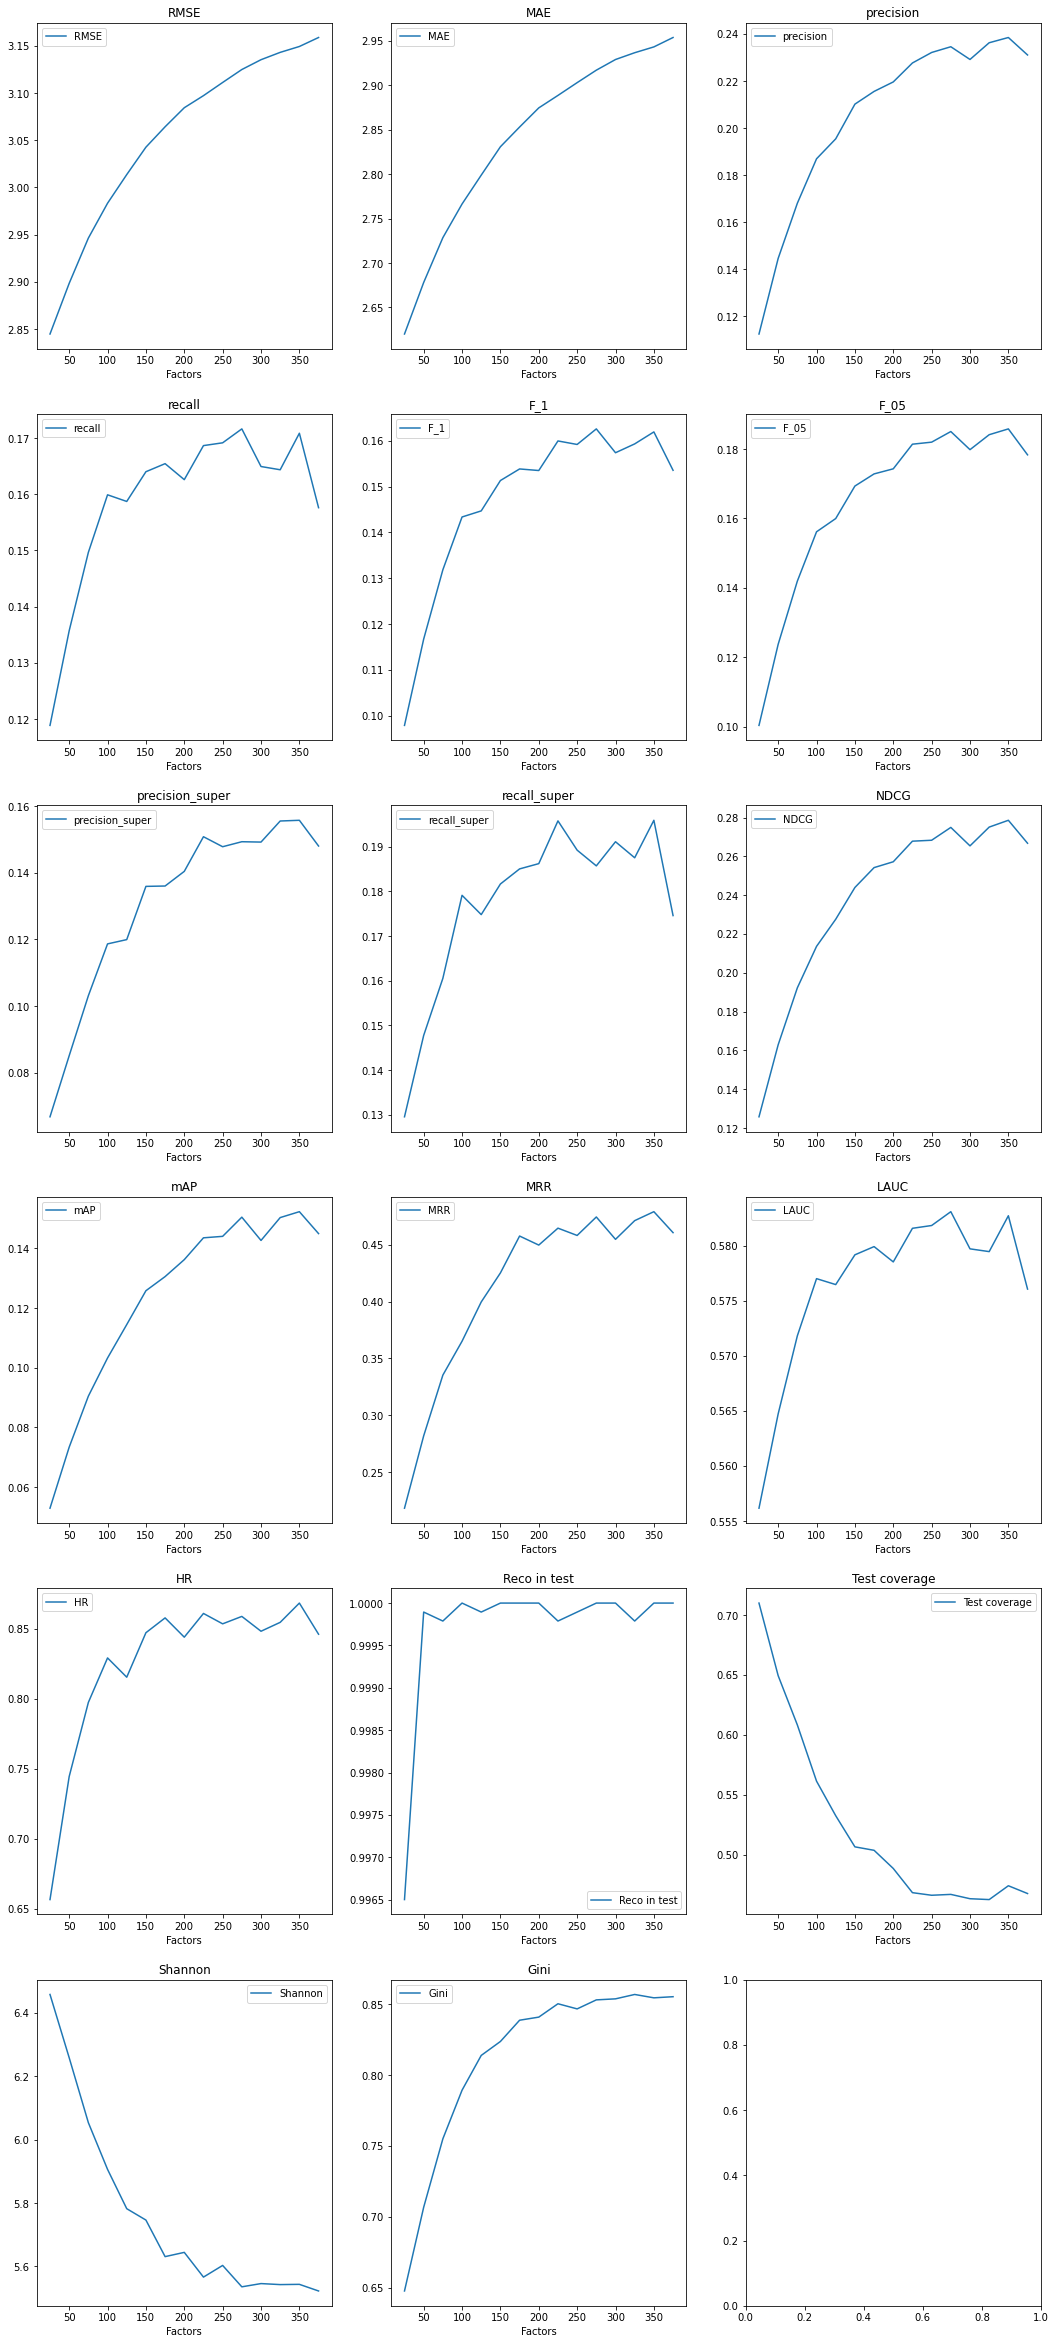

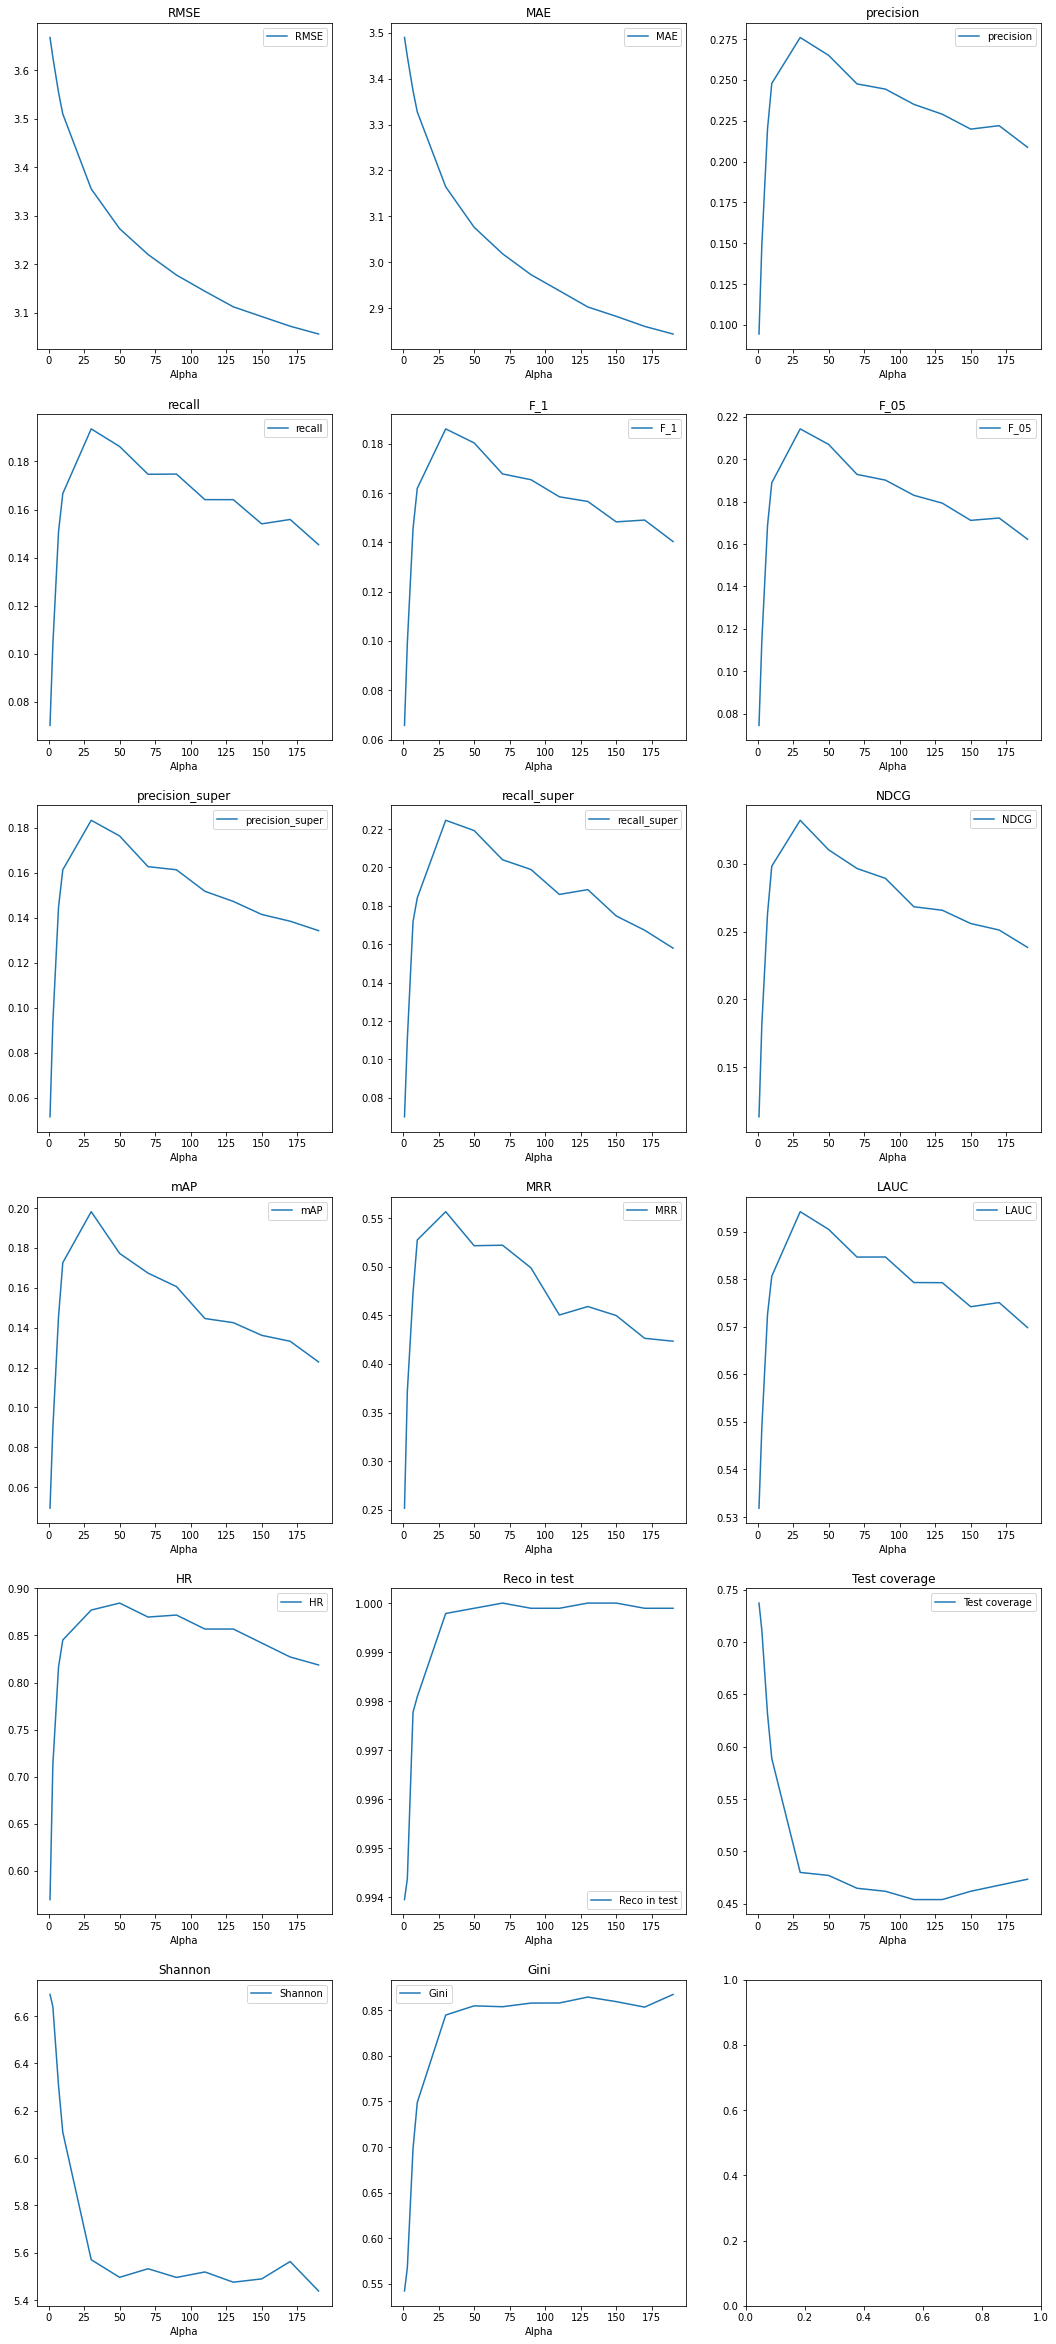

In [15]:
import evaluation_measures as ev

dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)